In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from operator import truediv
import seaborn as sns
from scipy.stats import pearsonr

def predict(y,level):
    x = np.linspace(0, 49, num=49)
    x2 = np.linspace(0, 51, num=51)
    poly = PolynomialFeatures(level, include_bias=False)
    poly.fit_transform(x[:, None])
    poly_model = make_pipeline(PolynomialFeatures(level),
                               LinearRegression())
    poly_model.fit(x[:, np.newaxis], y)
    y_predicted = poly_model.predict(x2[:, np.newaxis])
    return y_predicted

def predict_from_country(y_predicted,y,x,level):
    poly = PolynomialFeatures(level, include_bias=False)
    poly.fit_transform(x[:, None])
    poly_model = make_pipeline(PolynomialFeatures(level),
                               LinearRegression())
    poly_model.fit(x[:, np.newaxis], y)
    return poly_model.predict(y_predicted[:, np.newaxis])
    
def distortion(y,y_predicted):
    mean = np.mean(y)
    max_value = max(y)
    error = sum(pow(y_predicted[:49]-y, 2))
    return (error/mean)/(math.log10(max_value))

path = "/Users/ziedbk/Desktop/group01/datasets"
df_CO2 = pd.read_csv(path+'/greenhouse/co2_country_edgar.csv')
desired_prediction = ['Canada', 'China', 'United States', 'Japan', 'Russia', 'Brazil', 'India', 'EU28']
predictions_to_save = []
EU = []
data_co2 =[None] * 213
y_predicted =[None] * 213
x = np.linspace(0, 49, num=49)
x2 = np.linspace(0, 51, num=51)
for i in range (np.size(df_CO2['country_name'])):
    data_co2[i] = df_CO2.loc[df_CO2['country_name'] == df_CO2['country_name'][i]]
    
best_predictions =['Australia', 'Bangladesch', 'Burkina Faso', 'Central Africa Republic', 'Egypt', 'Finland', 'Iceland', 'India', 'Indonesia', 'Malaysia',
                   'Mauritus', 'Morocco', 'Philippines', 'Qatar', 'Sweden', 'Turkey', 'United Arab Emirates', 'Vietnam', 'Greece', 'North Korea', 'Netherlands']
for i in range (np.size(df_CO2['country_name'])-3): # delete 3 last lines from the array to limit the plots
    if data_co2[i].iloc[0][0] in best_predictions:
        y = (data_co2[i].iloc[0][1:].str.replace(',', '.', regex=True).astype(float)) # strings to floats

        name = (data_co2[i].iloc[0][0])
        predicted = predict(y,9)
        if name in desired_prediction:
            predictions_to_save.append([name, predicted])
        error = distortion(y, predicted)
        y_predicted[i] = np.append(np.append(name, predicted), error)
        
df = df_CO2
co2_country = df
for i in range (np.shape(co2_country)[0]):
    co2_country.iloc[i][1:] = (co2_country.iloc[i][1:].str.replace(',', '.', regex=True).astype(float))

to_predict = {}
for i in range (np.size(co2_country['country_name'])):
    if i != 210: # line 210 ['country_name'] is empty and this is causing troubles
        if data_co2[i].iloc[0][0] in best_predictions:
            y = (co2_country.iloc[i][2:])
            for ii in range (i, np.size(co2_country['country_name'])):
                if ii != 210:
                    if (i != ii):
                        yy = (co2_country.iloc[ii][2:])
                        corr = pearsonr(y.astype(float),yy.astype(float))[0] # pearson correlation used to find linear relations, spearman's correlation can be used to find non-linear relations
                        if (abs(corr) > 0.9):
                            #collect the list of countrys to predict
                            if ((co2_country.iloc[ii][0] in best_predictions) == False):
                                if co2_country.iloc[ii][0] in to_predict.keys():
                                    to_predict[co2_country.iloc[ii][0]] = to_predict[co2_country.iloc[ii][0]] + [co2_country.iloc[i][0]]
                                else:
                                    to_predict[co2_country.iloc[ii][0]] = [co2_country.iloc[i][0]]

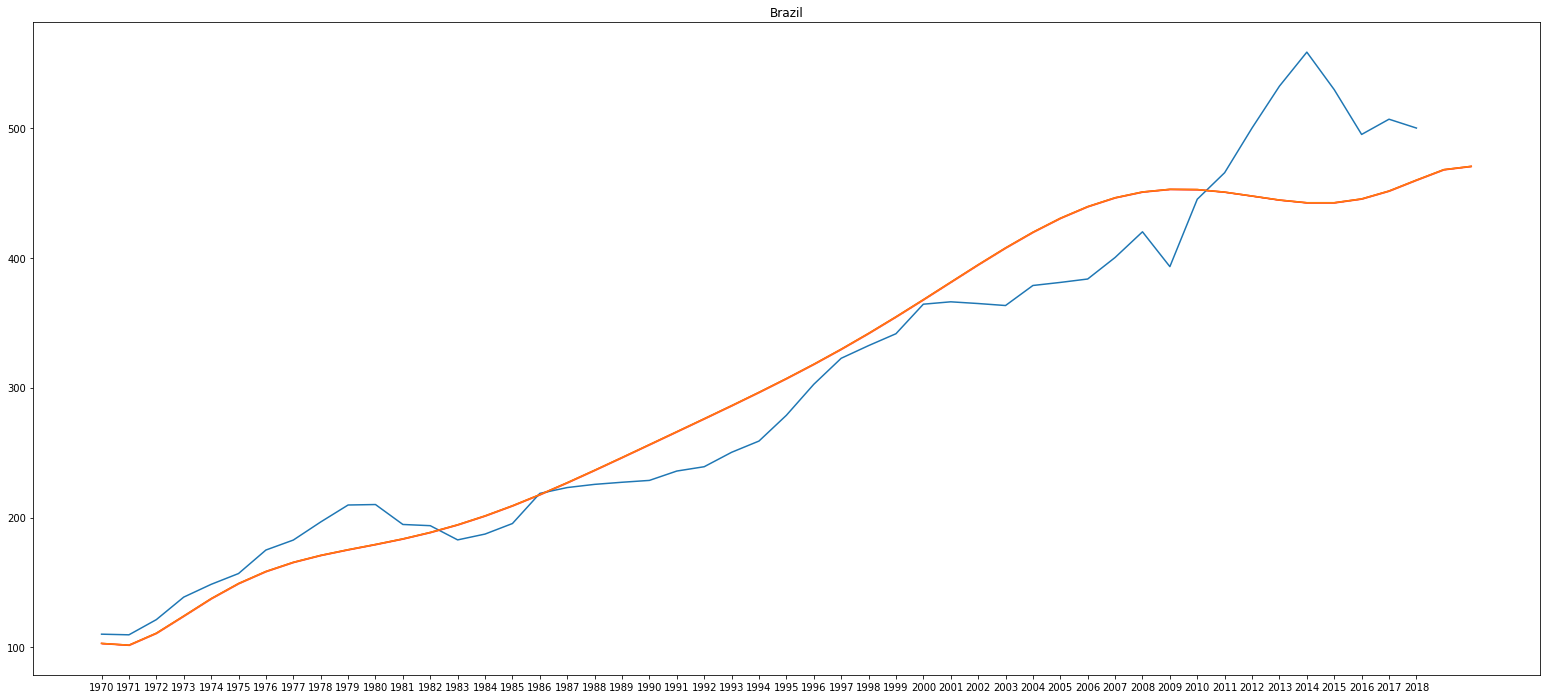

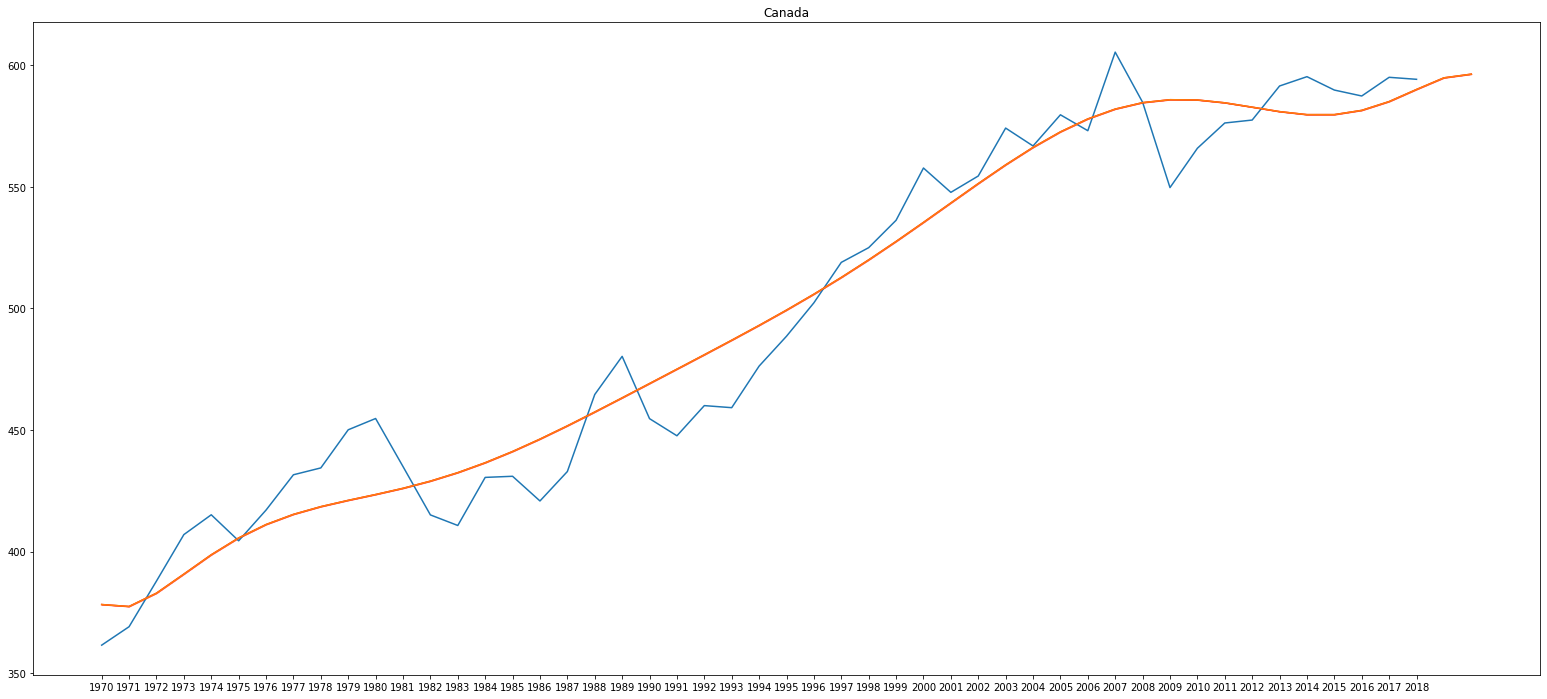

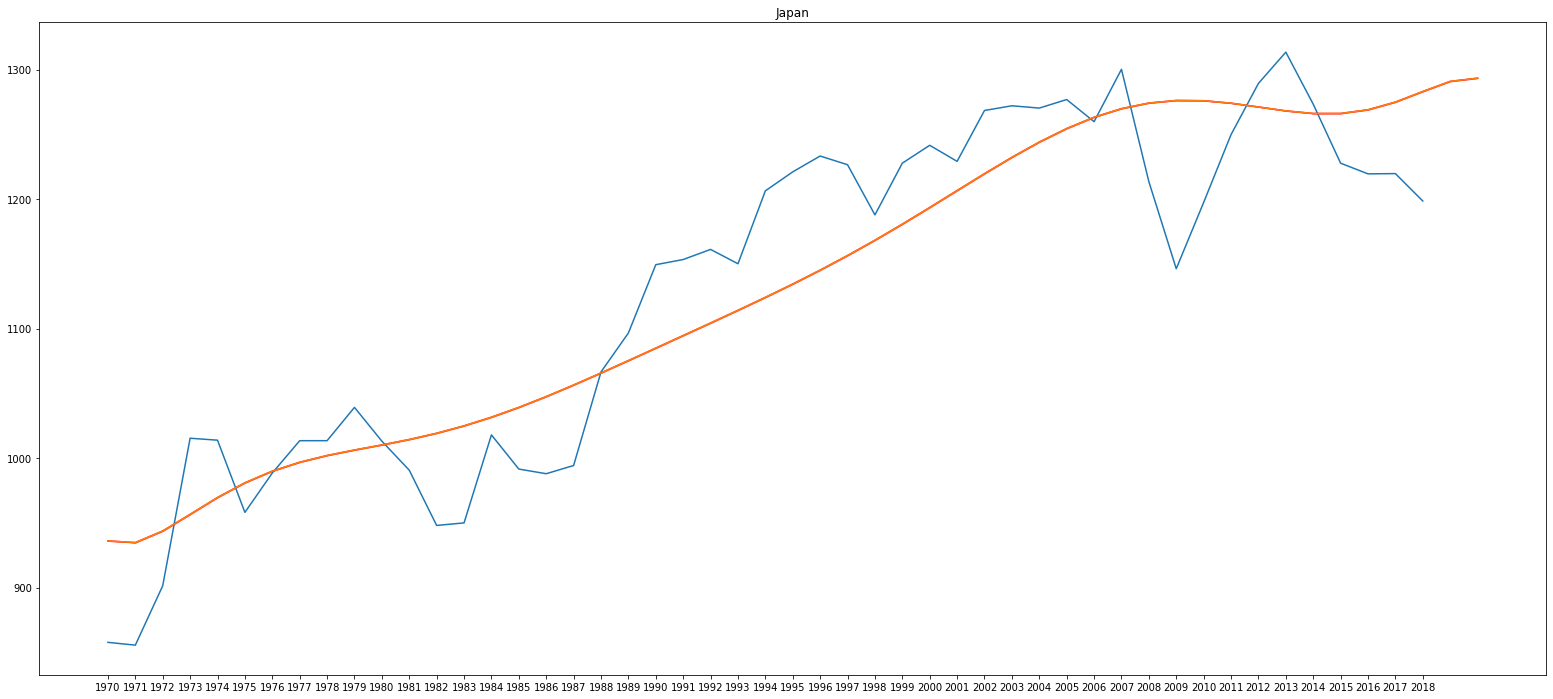

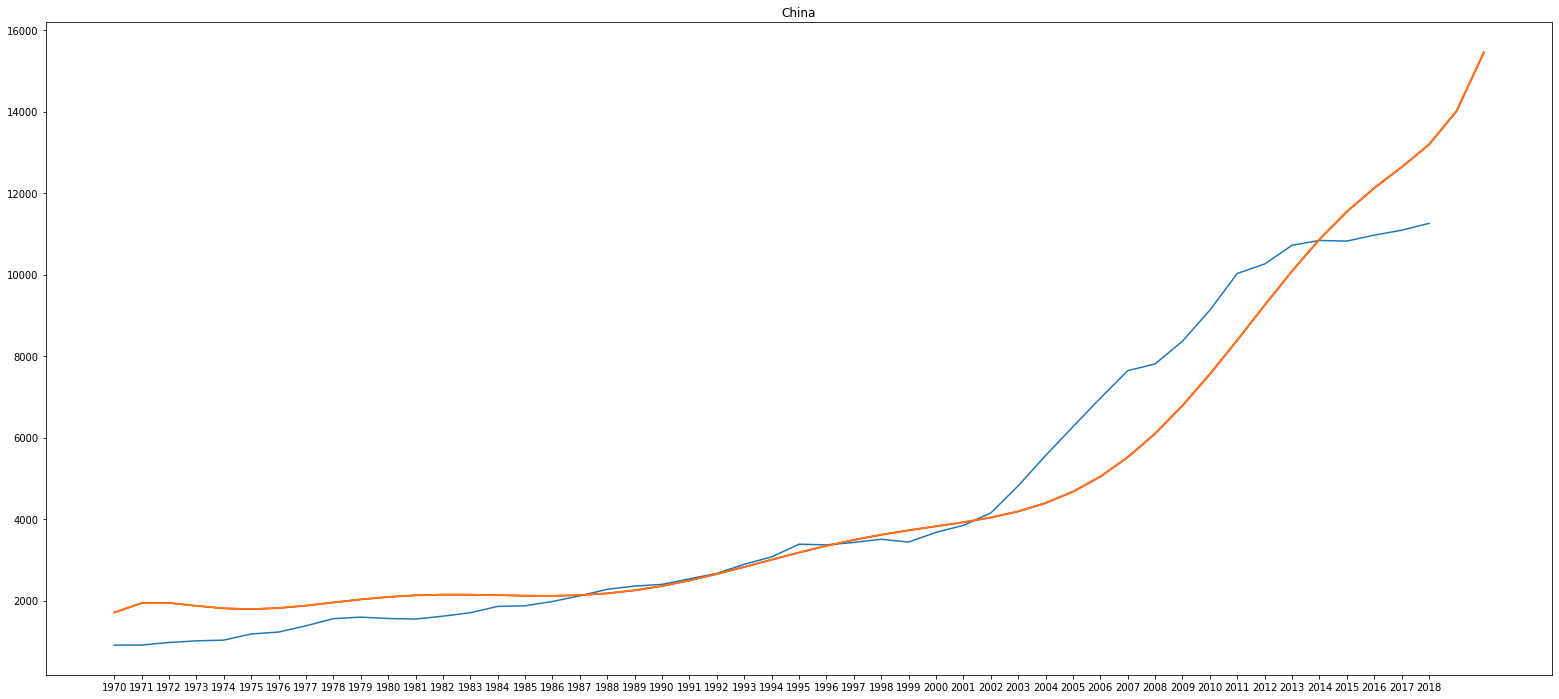

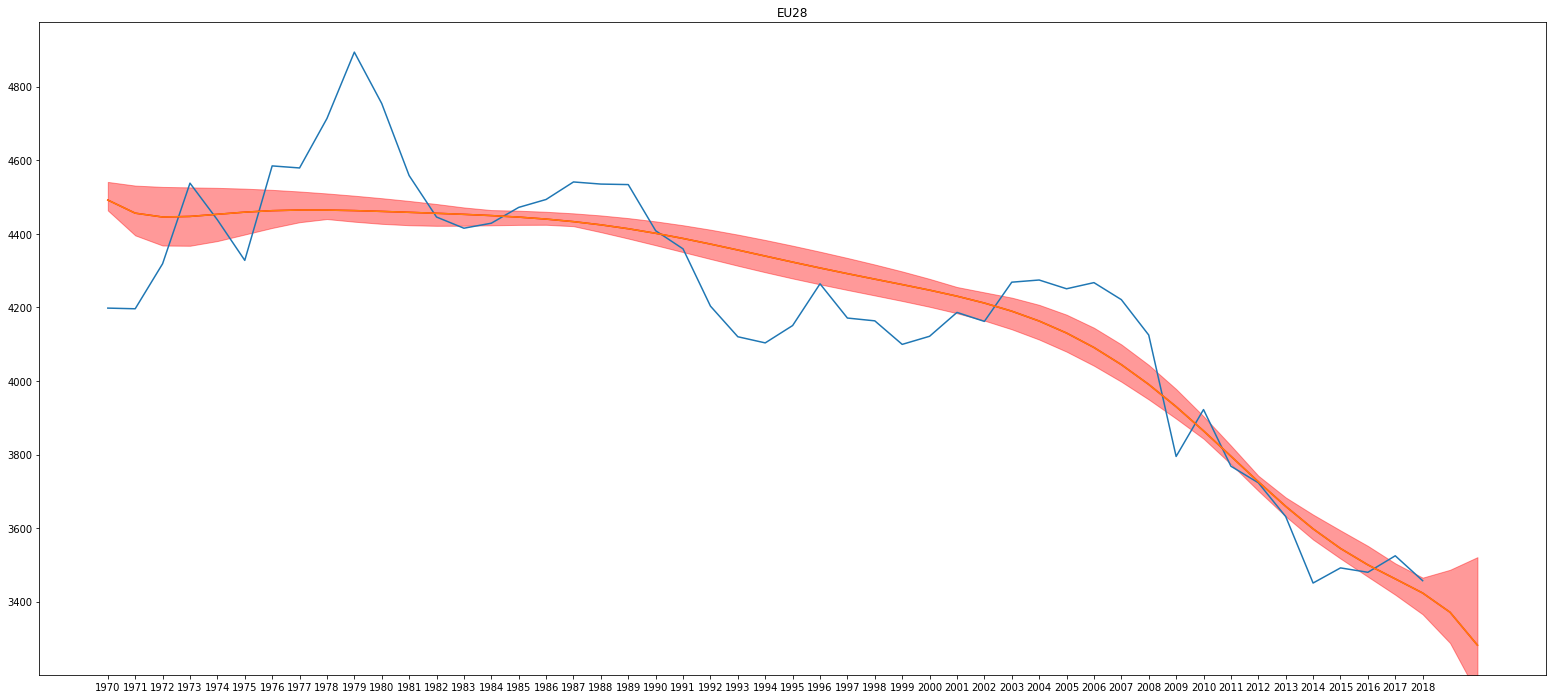

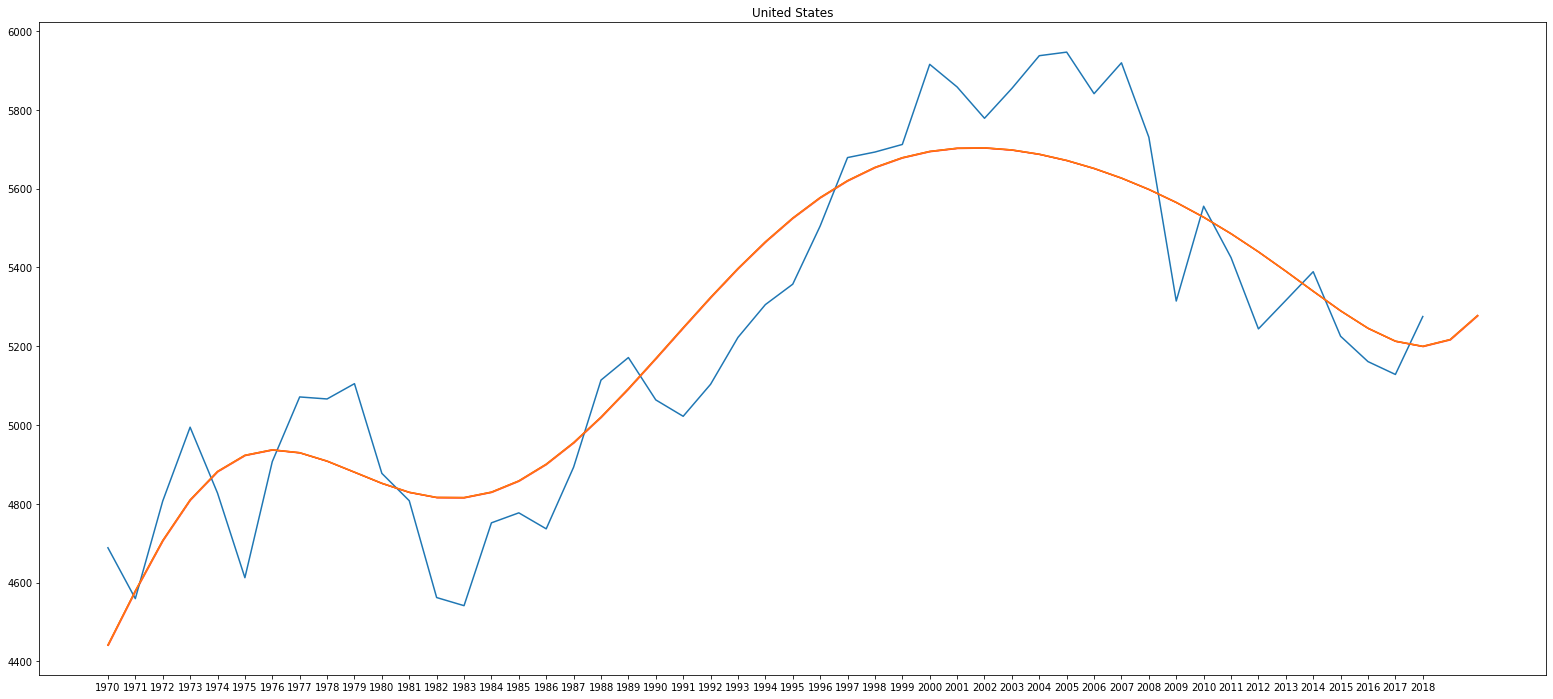

In [2]:
for country in to_predict:
    if country in desired_prediction:
        result = np.zeros((20,51))
        data = df_CO2.loc[df_CO2['country_name'] == country]
        y = (data.iloc[0][1:])
        maxvalue = np.zeros((51))
        minvalue = np.zeros((51))
        mean = np.zeros((51))
        fig = plt.figure(figsize=(27, 12))
        for ii in range(len(to_predict[country])):
            data = df_CO2.loc[df_CO2['country_name'] == to_predict[country][ii]]
            yy = (data.iloc[0][1:])
            yy_predicted = predict(yy,9)
            result[ii] = predict_from_country(yy_predicted, np.array(y), np.array(yy), 1)
        for i in range (51):
            maxvalue[i] = np.max(result[:ii+1,i])
            minvalue[i] = np.min(result[:ii+1,i])
            mean[i] = np.mean(result[:ii+1,i])
        if country in desired_prediction:
            predictions_to_save.append([country, mean])
        if country == 'EU28':
            EU.append([minvalue, maxvalue, mean])
                              
        plt.fill_between(np.linspace(0, 50, num=51), minvalue, maxvalue, color='red', alpha= 0.4)
        plt.plot(y)
        plt.plot(mean, color='red')
        plt.plot(mean)
        plt.title(country)

In [3]:
index = []
lists = []

for i in range (len(predictions_to_save)):
    index.append(predictions_to_save[i][0])
    lists.append(predictions_to_save[i][1])

In [4]:
ser1 = pd.DataFrame(lists ,index = index, columns = np.linspace(1970, 2020, 51))  
ser2 = pd.DataFrame(EU[0], index=['minvalue', 'maxvalue', 'meanvalue'], columns = np.linspace(1970, 2020, 51))

ser1.to_csv('predictions.csv')
ser2.to_csv('EU_predictions.csv')

In [5]:
'''import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

#data = csv.reader("/Users/ziedbk/Desktop/group01/prediction/co2_no_covid/zied/EU_predictions.csv")

with open("/Users/ziedbk/Desktop/group01/prediction/co2_no_covid/zied/predictions.csv", newline='') as f:
    reader = csv.reader(f)
    data = [tuple(row) for row in reader]
    data = (data)'''

#co2_df.index = np.linspace(1970, 2020, 51)
#ax = co2_df[2].plot()
#plt.fill_between(co2_df[0], co2_df[1], color='red', alpha=0.4)

'import pandas as pd\nimport numpy as np\nimport csv\nimport matplotlib.pyplot as plt\n\n#data = csv.reader("/Users/ziedbk/Desktop/group01/prediction/co2_no_covid/zied/EU_predictions.csv")\n\nwith open("/Users/ziedbk/Desktop/group01/prediction/co2_no_covid/zied/predictions.csv", newline=\'\') as f:\n    reader = csv.reader(f)\n    data = [tuple(row) for row in reader]\n    data = (data)'